# Predicting outcomes of stroke based on Lymphocyte Profiles
This notebook is used to create a prediction algorithm for the outcomes of stroke

In [105]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow.keras
import random
from scipy.stats import norm 
import seaborn as sns
import math as m

In [106]:
df = pd.read_csv('./spanish_data.csv', na_values=[' ', 'Nan'])
df_full_labels = pd.read_csv('./spanish_data_full_labels.csv', encoding='ISO-8859-1')

In [107]:
columns_full_names = df_full_labels.columns
columns = df.columns
for i in range(len(columns)):
    print("'" + columns_full_names[i] + "'" + "'" + columns[i] + "'")

'Gender''GENDER'
'Age''AGE'
'History of hypertension''HTA'
'History of Diabetes Mellitus''DM'
'History of Dyslipidemia''DYSL'
'History of Atrial Fibrillation''AF'
'History of ischemic heart disease''IC'
'Alcohol Consumption''ALC'
'Smoking habit''SMOK'
'Previous treatment with Antiaggregants''AAGRE'
'Previous treatment with statins''STAT'
'Previous treatment with Anticoagulants''AANCO'
'Previous treatment with Antidiabetic drugs''ADO'
'Previous treatment with Antihypertensives drugs''AHT'
'Leucocytes at admission''LEUC'
'% Lymphocytes at admission''LINPH_P'
'Total Lymphocytes at admission''LINPH_T'
'Basal Glucose levels''GLUC'
'INR at admission''INR'
'Platelets at admission''PLAT'
'Hemoglobin at admission''HB'
'ESR at admission''ESR'
'Fibrinogen at admission''FIBR'
'Creatinine at admission''CREAT'
'proBNP serum levels at 24 hours''proBNP'
'hs-CRP at admission''hs_CRP'
'Basal NIHSS''NIHSS_b'
'Recanalization treatment''RECAN'
'TOAST Criteria''TOAST'
'Infarct volume at day 7 (cc)''VOL_7d'


In [108]:
df.dropna(axis=0, inplace=True, thresh=np.round(0.8*len(df.columns)))

In [109]:
def hist_gen(df, column, colours, bins_val=5):
    
    assert type(colours) is list, 'Not a list'
    assert type(df).__name__ == 'DataFrame', 'Please use pandas DataFrame structure'
    assert type(column) is str, 'Column name not given'

    
    plt.figure(figsize=(20,10))
    plt.grid(False)
    n, bins, patches = plt.hist(df[column], bins=bins_val)
    
    if len(colours) < len(patches):
        print('Warning: There should be the same number of colours as bars if more colours are needed')
        x = -(-len(patches)//len(colours)) # round always rounds down and so does //, therefore using
        # a negative value will always round up
        colours = colours*x
    
    for i in range(len(patches)):
        c = colours[i]
        patches[i].set_fc(c)
    
    #plt.ylim(max(df[column].value_counts()) + (max(df[column].value_counts()*0.4)))
    plt.xlabel(f'{column} concentration')
    plt.ylabel(f'No. of Patients with similar {column}')
    plt.title(f'Distribution of {column}')
    plt.savefig(f'./Distribution of {column}.png')

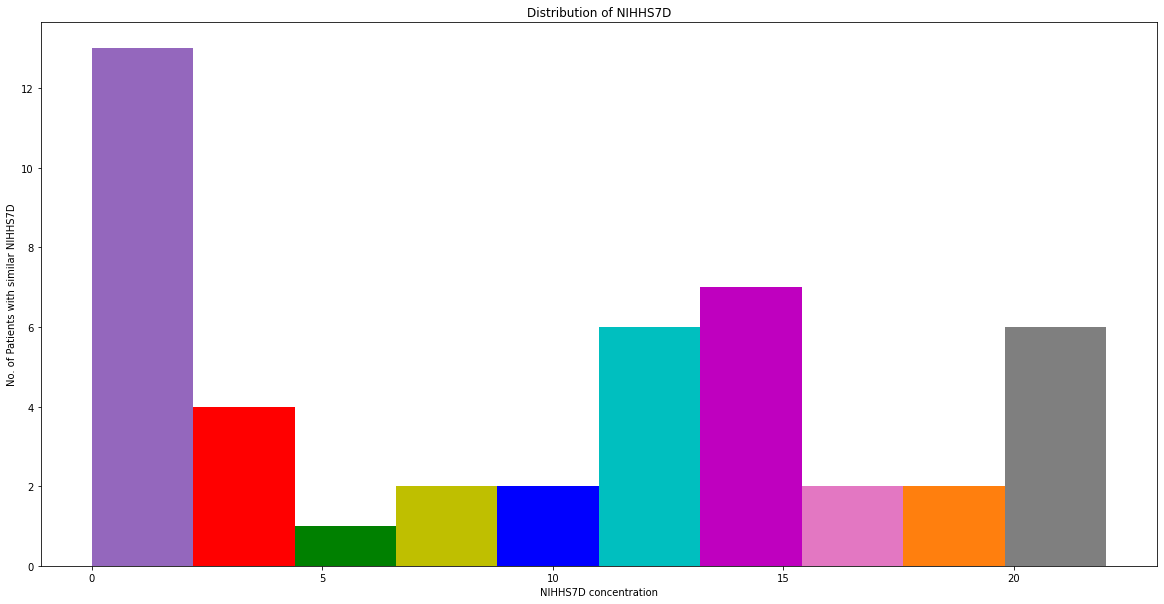

In [110]:
hist_gen(df, 'NIHHS7D', ['tab:purple', 'r', 'g', 'y','b', 'c', 'm', 'tab:pink', 'tab:orange', 'tab:grey'], 10)

In [111]:
long_term_target = df[['mRS_3m', 'FO_3m']]
long_term_features = df[['LEUC','LINPH_T','Treg_T_b', 'Treg_T_48h', 'Treg_T_72h', 'IL10_b', 'IL10_48h',
        'IL10_72h', 'NIHSS_b', 'NIHSS_D', 'NIHSS48', 'NIHSS72', 'NIHHS7D', 'hs_CRP', 'ESR', 'HB', 'PLAT']]
long_term_target_w_NIHSS = df[['mRS_3m', 'FO_3m', 'NIHSS_3m']]

In [112]:
target = df[['NIHSS_b', 'NIHSS_D', 'NIHSS_3m', 'mRS_3m', 'FO_3m', 'NIHSS48', 'NIHSS72', 'NIHHS7D']]
features = df[['Treg_T_b', 'Treg_T_48h', 'Treg_T_72h']]

In [113]:
features.fillna(float(0),inplace=True)
target.fillna(float(0),inplace=True)

/tmp/ipykernel_10172/3956363315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(float(0),inplace=True)
/tmp/ipykernel_10172/3956363315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.fillna(float(0),inplace=True)


In [114]:
long_term_target.fillna(0,inplace=True)
long_term_target_w_NIHSS.fillna(0,inplace=True)

/tmp/ipykernel_10172/2508957403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_term_target.fillna(0,inplace=True)
/tmp/ipykernel_10172/2508957403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_term_target_w_NIHSS.fillna(0,inplace=True)


In [115]:
for i in range(len(long_term_features)):
    j = 3
    k = j*2
    
    if np.isnan(long_term_features.iloc[i,j+1]) == True:
        long_term_features.iloc[i,j+1] = (long_term_features.iloc[i,j]/2)
    else:
        if np.isnan(long_term_features.iloc[i,j]) == True:
            long_term_features.iloc[i,j] = (long_term_features.iloc[i,j-1] + long_term_features.iloc[i,j+1])/2
        
    if np.isnan(long_term_features.iloc[i,k+1]) == True:
        long_term_features.iloc[i,k+1] = (long_term_features.iloc[i,k]/2)
    else:
        if np.isnan(long_term_features.iloc[i,k]) == True:
            long_term_features.iloc[i,k] = (long_term_features.iloc[i,k-1] + long_term_features.iloc[i,k+1])/2
long_term_features.fillna(0,inplace=True)

/tmp/ipykernel_10172/2898839969.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_term_features.fillna(0,inplace=True)


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
long_term_features = scaler.fit_transform(long_term_features)
features = scaler.fit_transform(features)

In [13]:
from sklearn import model_selection
train_data, test_data, train_label, test_label = model_selection.train_test_split(long_term_features, 
                                                                                  long_term_target,
                                                                                  test_size=0.2,
                                                                                  shuffle=True)

In [14]:
try:
    n_inputs, n_outputs = train_data.shape[1], train_label.shape[1]
except:
    try:
        n_inputs = train_data.shape[1]
        n_outputs = 1
    except:
        n_inputs = 1
        n_outputs = 1

In [15]:
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)

In [16]:
x = 0
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        if np.isnan(train_data[i][j]) == True:
            x += 1
print(x)

0


In [17]:
seed = 100
tf.random.set_seed(
    seed
)

In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(n_inputs,)),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_outputs, activation='relu')
])

2022-09-02 10:55:24.204880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 10:55:24.231786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-02 10:55:24.231801: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-02 10:55:24.232039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [19]:
model.compile(optimizer='adam',
              loss ='mean_absolute_error',
              metrics=['acc'])

In [20]:
import time
timer = time.time()
epoch = 5000
history = model.fit(
    train_data, 
    train_label, 
    epochs=epoch, 
    validation_split=0.2,
    verbose=0, batch_size=512
)
print(time.time() - timer)

59.58462977409363


In [21]:
test_loss, test_acc = model.evaluate(test_data,test_label)

1/1 [==============================] - 0s 11ms/step - loss: 0.3256 - acc: 0.9375


In [22]:
print('Accuracy: {}%'.format(np.round(test_acc,4)*100),
     '\nLoss: {}'.format(test_loss))

Accuracy: 93.75% 
Loss: 0.325605571269989


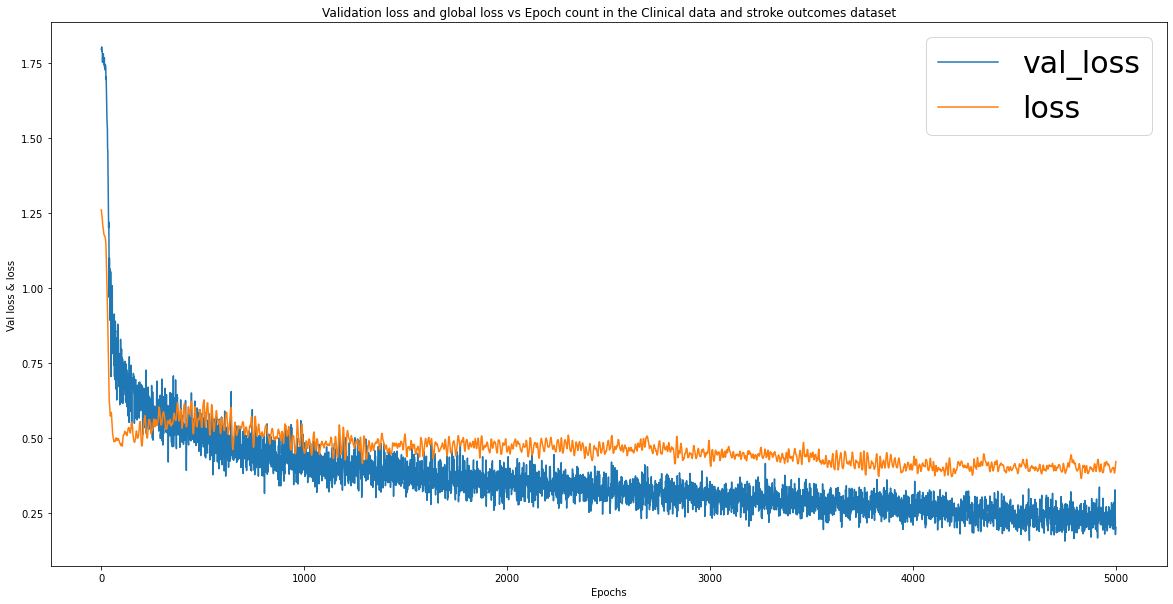

In [30]:
plt.figure(figsize=(20,10))
plt.plot(list(range(epoch)), history.history['loss'], history.history['val_loss'])
plt.title('Validation loss and global loss vs Epoch count in the Clinical data and stroke outcomes dataset')
plt.xlabel('Epochs')
plt.ylabel('Val loss & loss')
plt.legend(('val_loss', 'loss'), prop={'size':30})
plt.savefig('./val_lossVSloss.jpg')

In [24]:
list_of_predictions = []
for i in range(len(test_data)):
    a = test_data[i]
    a = np.expand_dims(a, 0)
    b = np.round(model.predict(a, verbose=0),1)
    list_of_predictions.append(b[0].tolist())
preds = model.predict(test_data,verbose=0)

In [25]:
preds, test_label

(array([[3.6014047, 0.       ],
        [0.       , 1.0017569],
        [5.7504344, 0.       ],
        [0.       , 1.3220587],
        [3.6566186, 0.       ],
        [1.8424201, 1.0005175],
        [1.8952647, 1.0002555],
        [4.4894924, 0.       ],
        [4.280587 , 0.       ],
        [6.4344397, 0.       ],
        [4.6222906, 0.       ],
        [4.4630213, 0.       ],
        [1.2817175, 1.0010661],
        [2.3500693, 0.3994426],
        [1.8952647, 1.0002555],
        [3.0658448, 0.       ]], dtype=float32),
 array([[3, 0],
        [2, 1],
        [6, 0],
        [0, 1],
        [3, 0],
        [2, 1],
        [2, 1],
        [4, 0],
        [6, 0],
        [6, 0],
        [6, 0],
        [4, 0],
        [2, 1],
        [2, 1],
        [2, 1],
        [3, 0]]))

In [26]:
corr = 0
for i in range(len(preds)):
    for j in range(len(preds[i])):
        print(float(np.round(preds[i][j])), float(test_label[i][j]))
        if float(np.round(preds[i][j])) == float(test_label[i][j]):
            corr += 1

print(corr)                     
print(corr/((i+1)*(j+1)))

4.0 3.0
0.0 0.0
0.0 2.0
1.0 1.0
6.0 6.0
0.0 0.0
0.0 0.0
1.0 1.0
4.0 3.0
0.0 0.0
2.0 2.0
1.0 1.0
2.0 2.0
1.0 1.0
4.0 4.0
0.0 0.0
4.0 6.0
0.0 0.0
6.0 6.0
0.0 0.0
5.0 6.0
0.0 0.0
4.0 4.0
0.0 0.0
1.0 2.0
1.0 1.0
2.0 2.0
0.0 1.0
2.0 2.0
1.0 1.0
3.0 3.0
0.0 0.0
25
0.78125


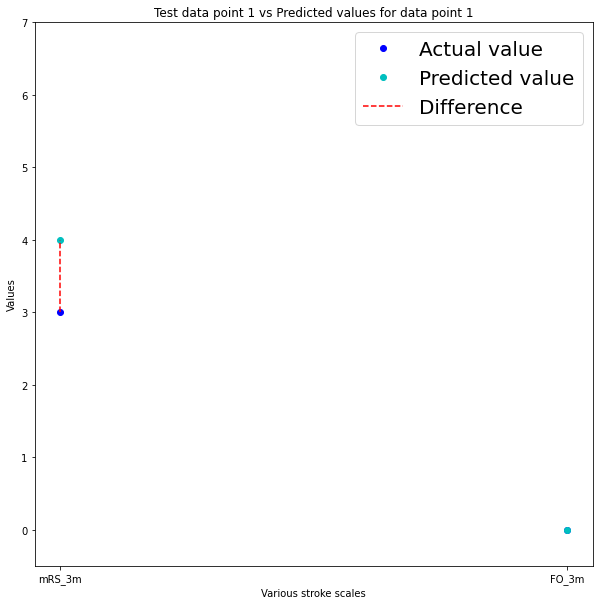

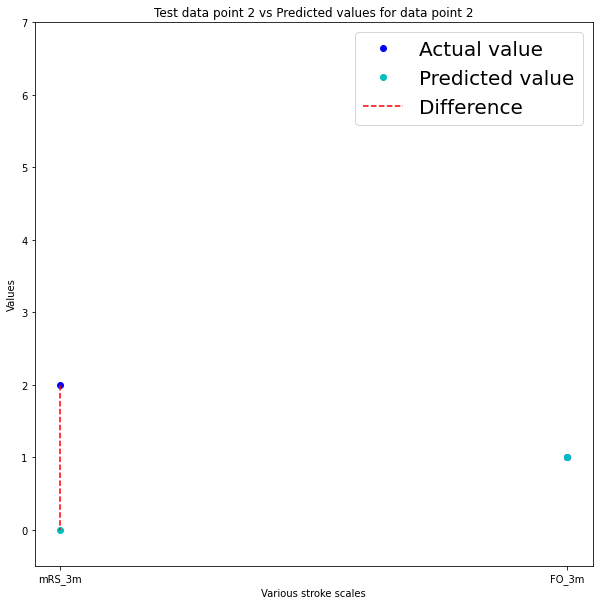

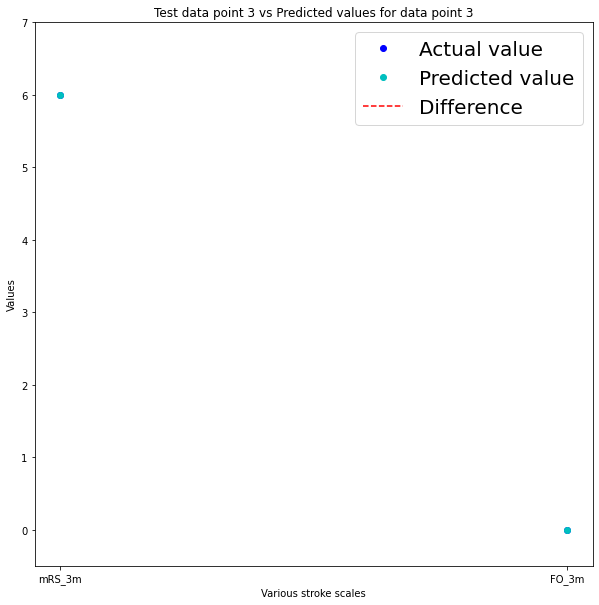

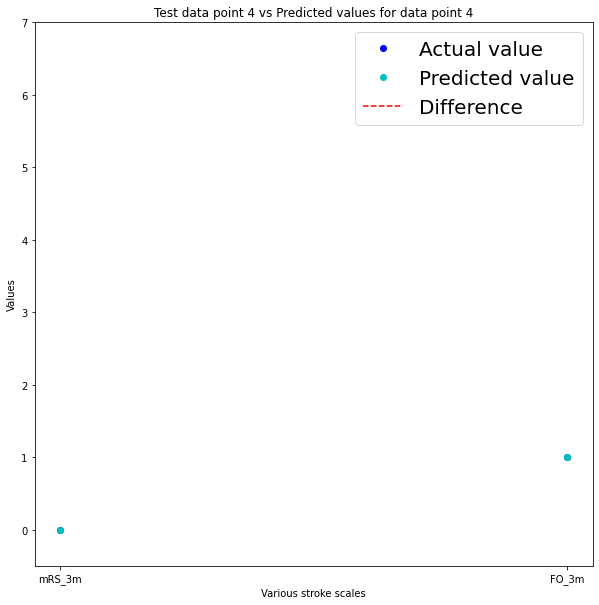

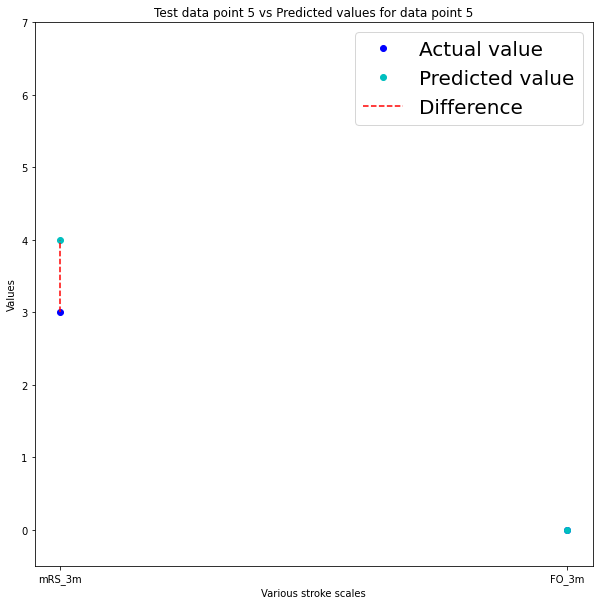

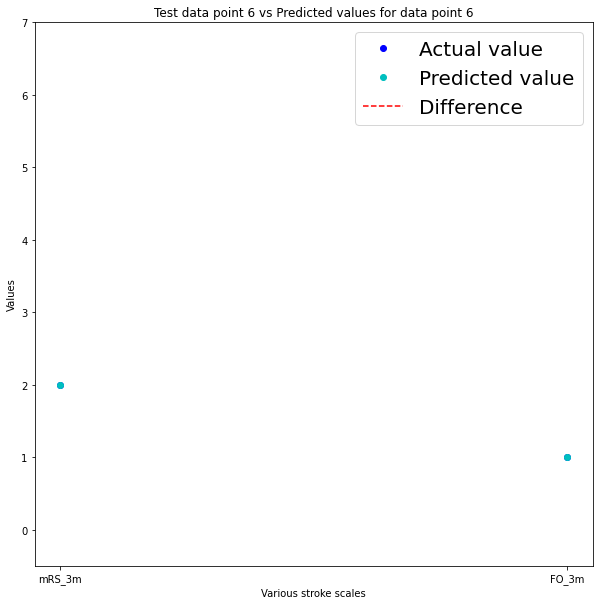

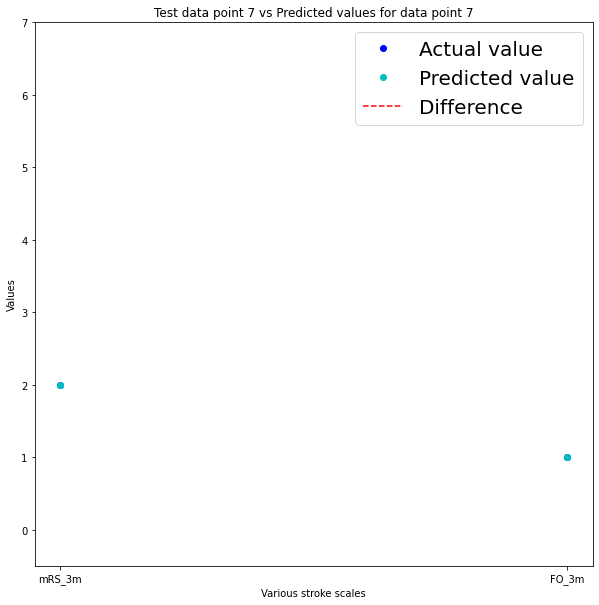

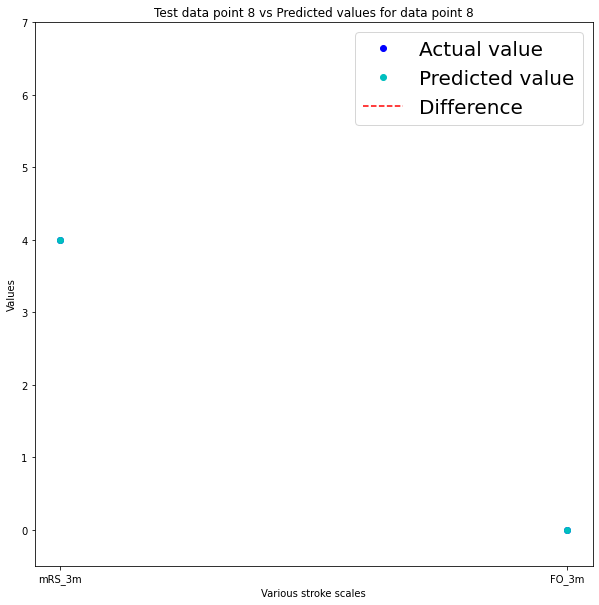

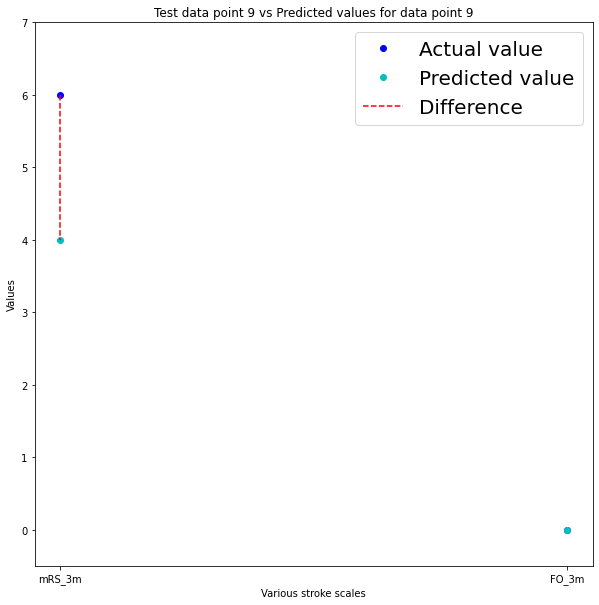

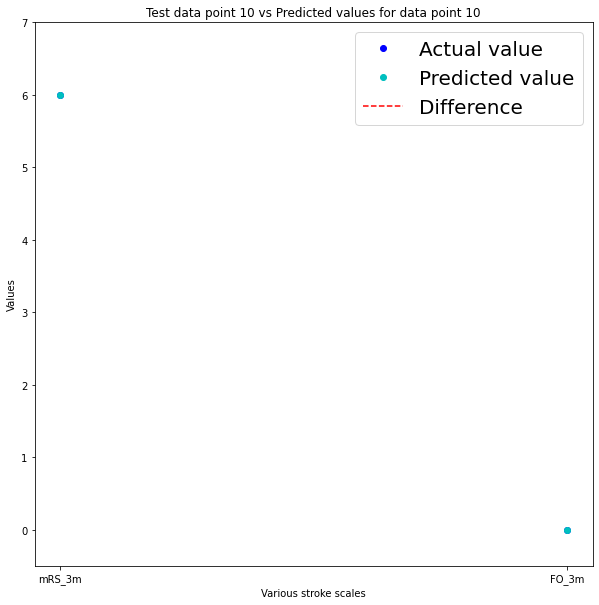

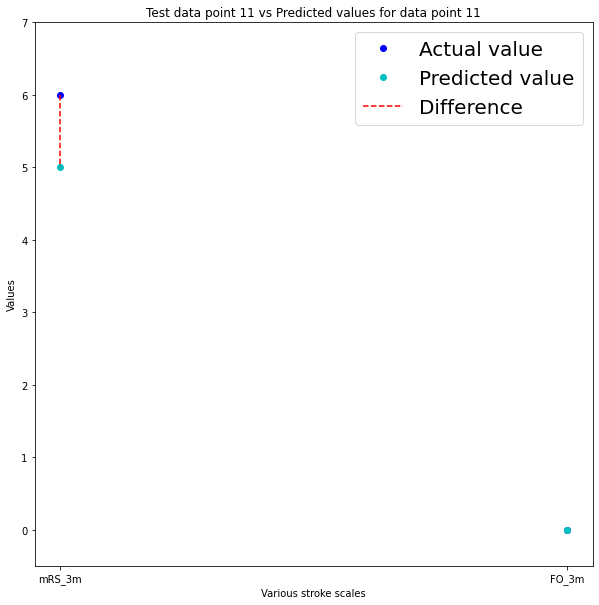

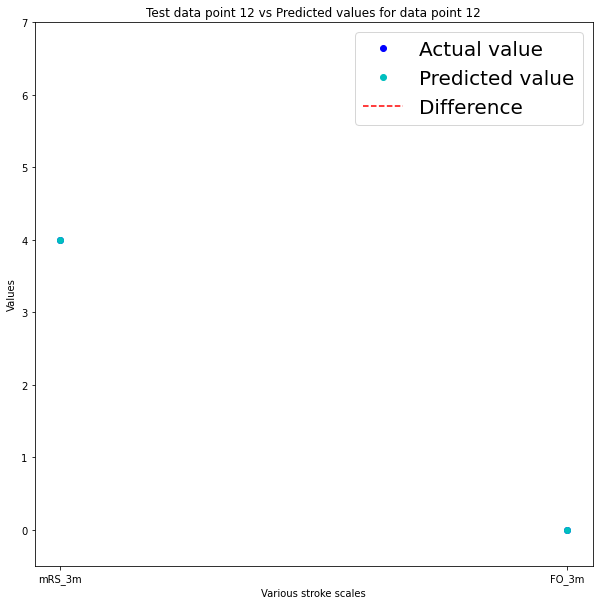

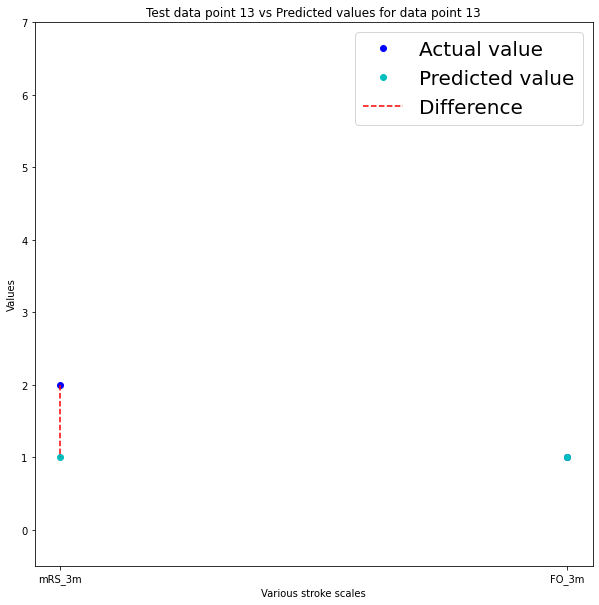

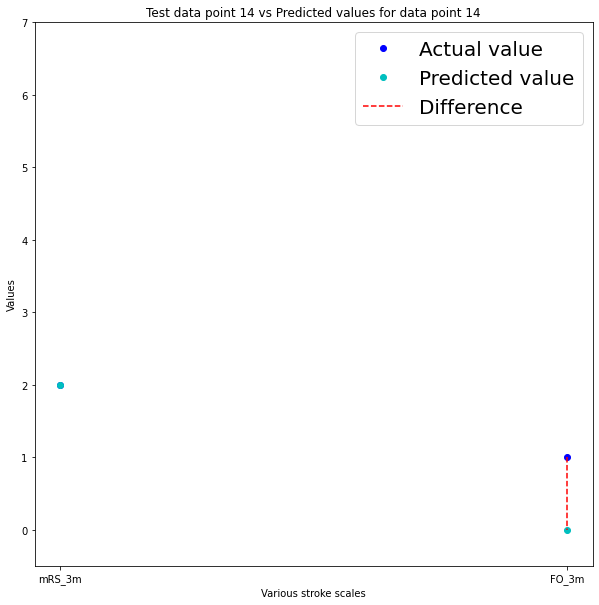

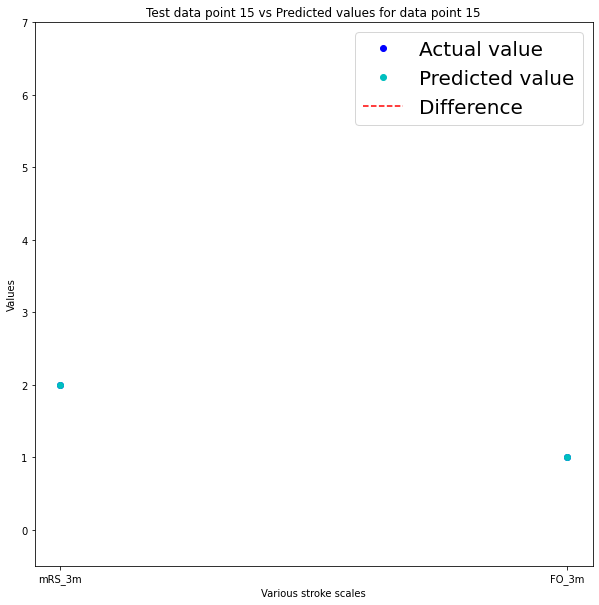

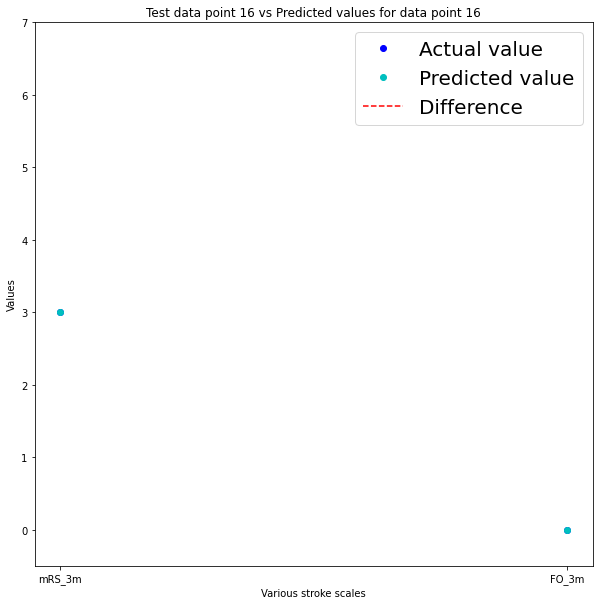

In [27]:
linspace = list(long_term_target.columns)

for i in range(0 ,len(test_label)):
    plt.figure(figsize=(10,10))
    plt.ylim(-0.5,7)
    plt.plot(linspace, test_label[i],'bo', linestyle='None')
    plt.plot(linspace, np.round(preds[i]),'co', linestyle='None')
    plt.vlines(linspace, test_label[i], np.round(preds[i]),'r' ,linestyle = '--')
    plt.title(f'Test data point {str(i+1)} vs Predicted values for data point {str(i+1)}')
    plt.xlabel('Various stroke scales')
    plt.ylabel('Values')
    plt.legend(('Actual value', 'Predicted value', 'Difference'), prop={'size':20})
    plt.savefig('./Spanish Data Value vs Predicted value case' + str(i+1) +'.jpg')

In [117]:
from sklearn import model_selection
train_data, test_data, train_label, test_label = model_selection.train_test_split(long_term_features, 
                                                                                  long_term_target_w_NIHSS,
                                                                                  test_size=0.2,
                                                                                  shuffle=True)

In [120]:
try:
    n_inputs, n_outputs = train_data.shape[1], train_label.shape[1]
except:
    try:
        n_inputs = train_data.shape[1]
        n_outputs = 1
    except:
        n_inputs = 1
        n_outputs = 1

In [121]:
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)

In [122]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(n_inputs,)),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_outputs, activation='relu')
])

2022-09-05 15:12:05.836297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 15:12:06.841218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-05 15:12:06.841232: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-05 15:12:06.843002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [123]:
model.compile(optimizer='adam',
              loss ='mean_absolute_error',
              metrics=['acc'])

In [124]:
import time
timer = time.time()
epoch = 5000
history = model.fit(
    train_data, 
    train_label, 
    epochs=epoch, 
    validation_split=0.2,
    verbose=0, batch_size=512
)
print(time.time() - timer)

57.961477756500244


In [125]:
test_loss, test_acc = model.evaluate(test_data,test_label)

1/1 [==============================] - 0s 11ms/step - loss: 1.5273 - acc: 0.6250


In [126]:
print('Accuracy: {}%'.format(np.round(test_acc,4)*100),
     '\nLoss: {}'.format(test_loss))

Accuracy: 62.5% 
Loss: 1.5272685289382935


In [127]:
preds = model.predict(test_data,verbose=0)

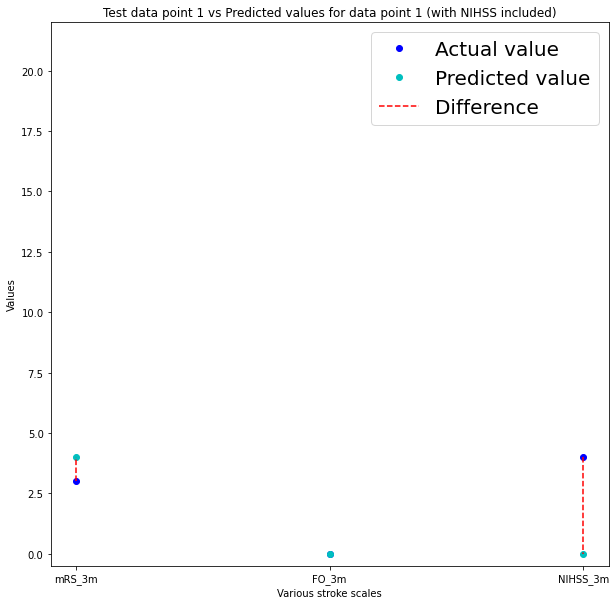

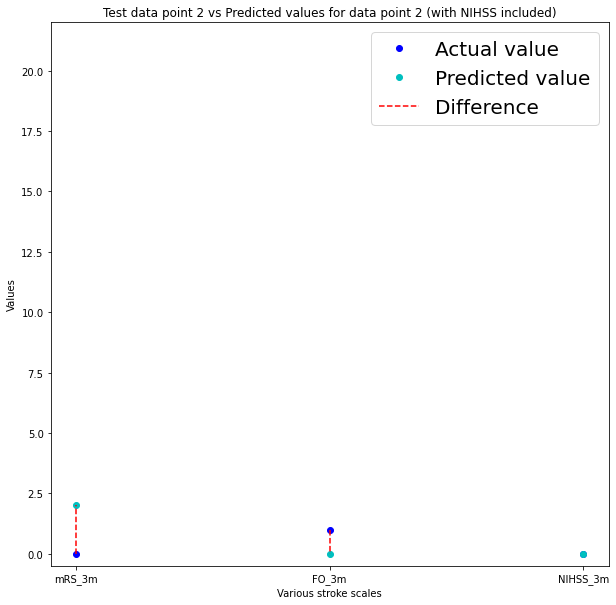

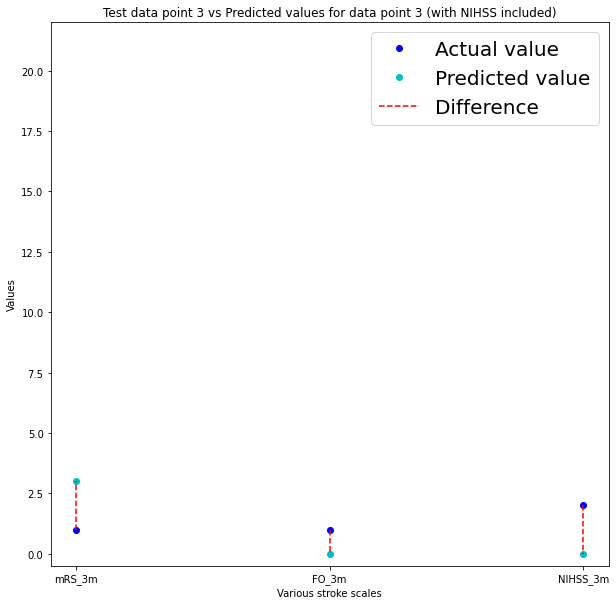

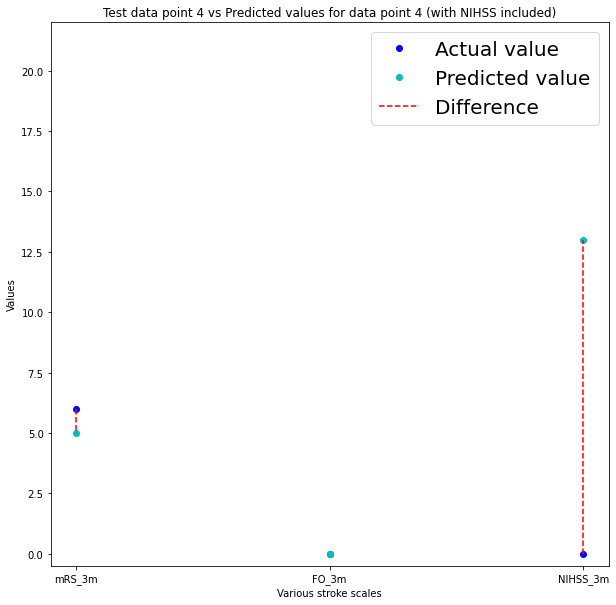

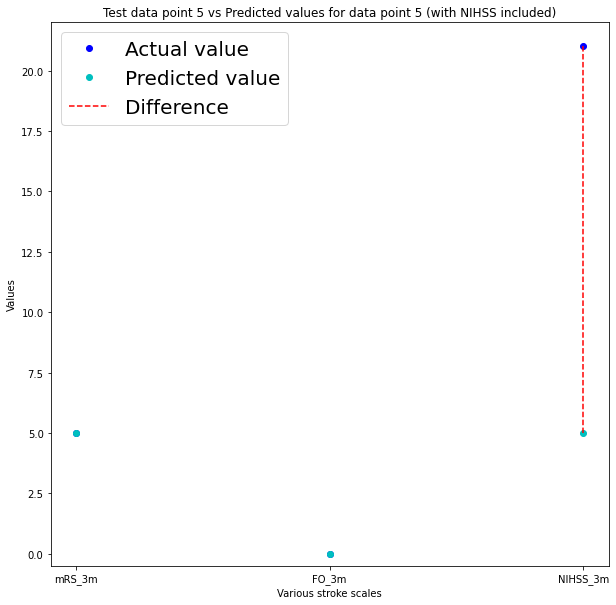

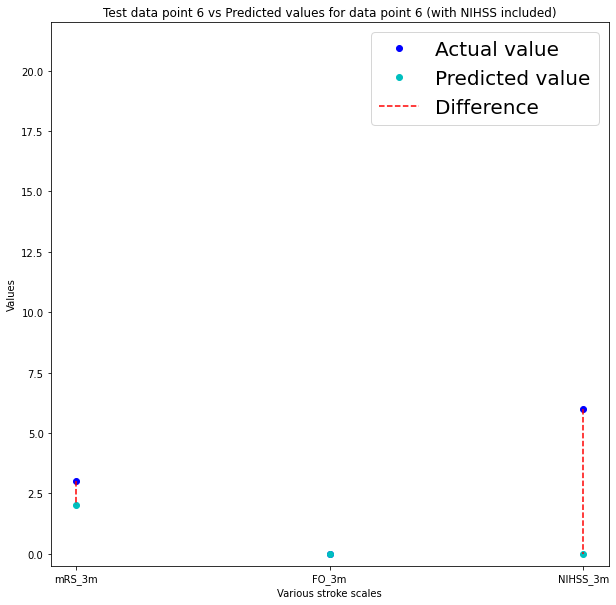

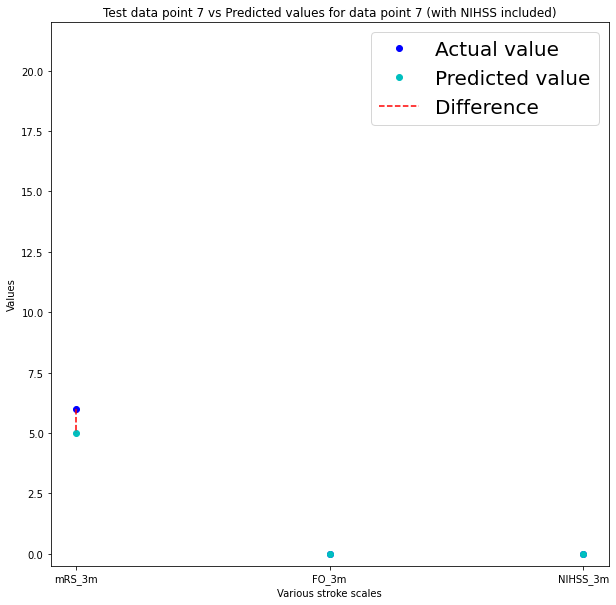

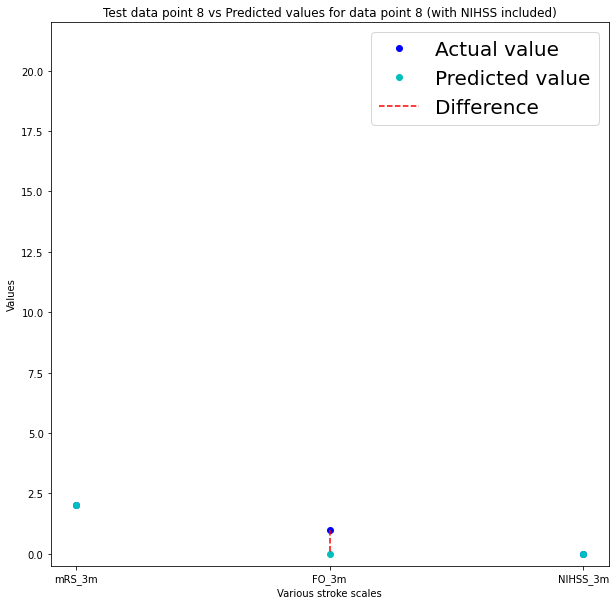

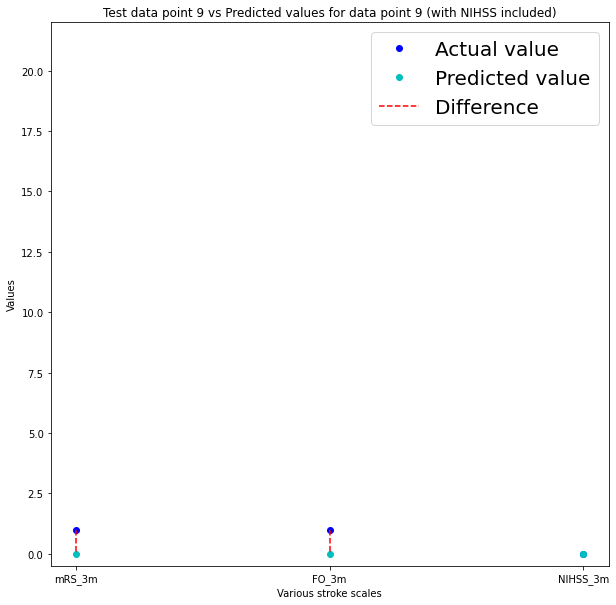

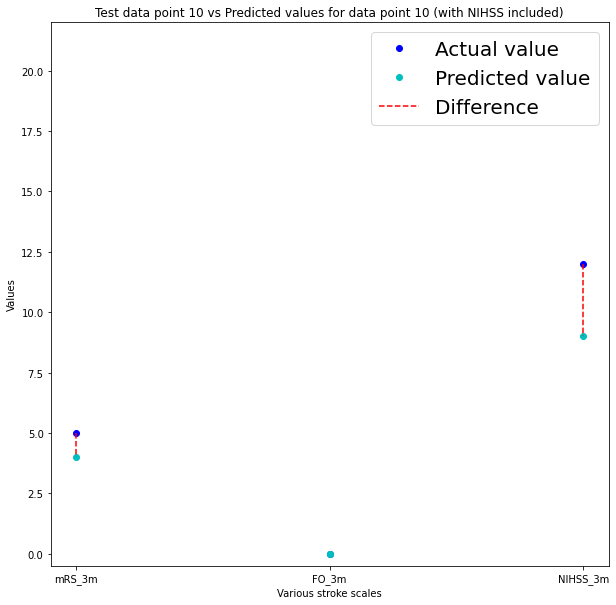

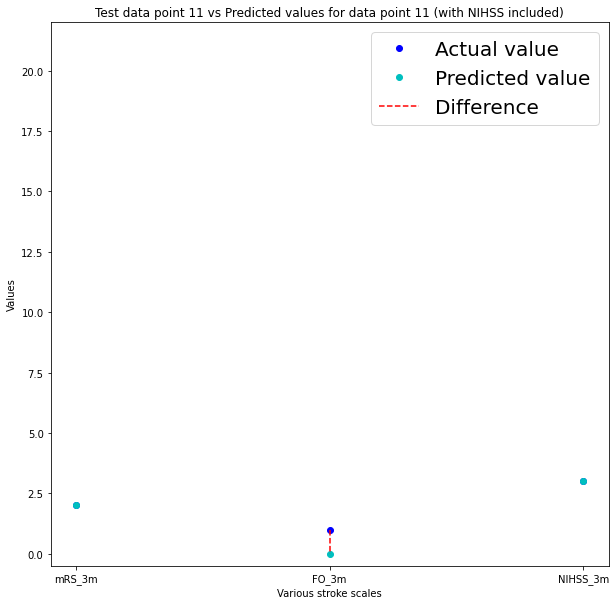

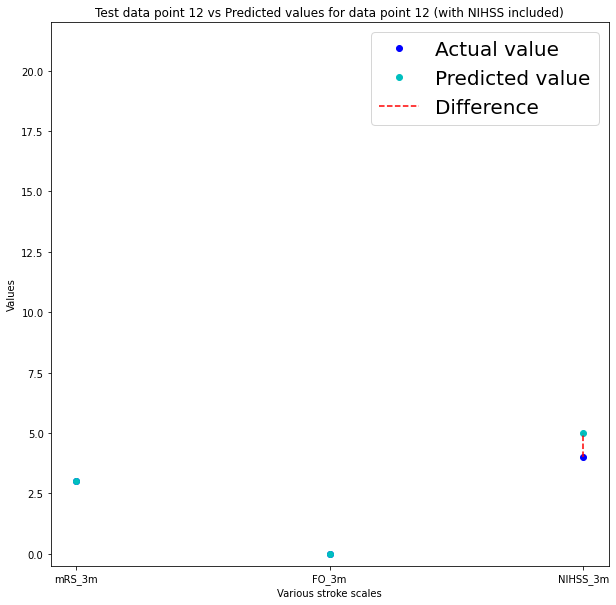

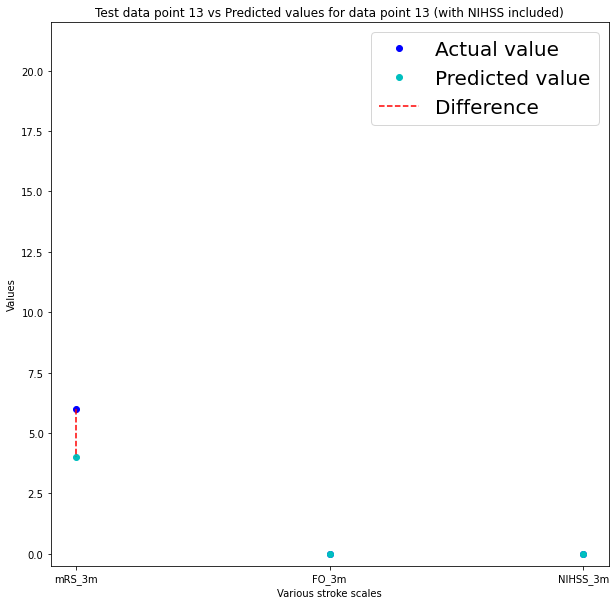

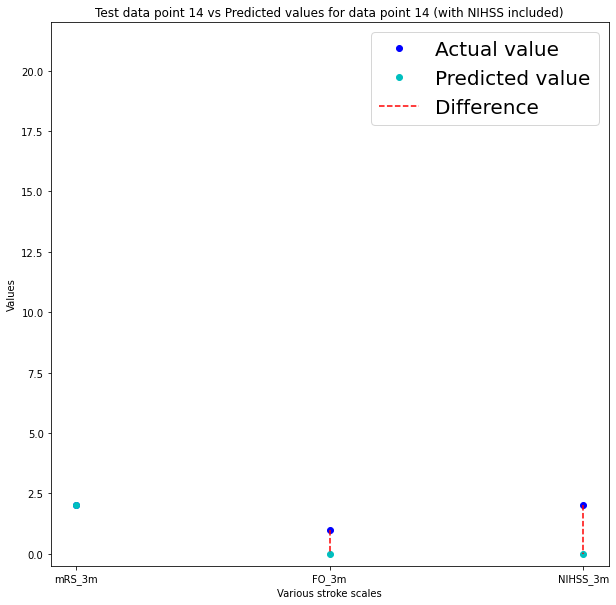

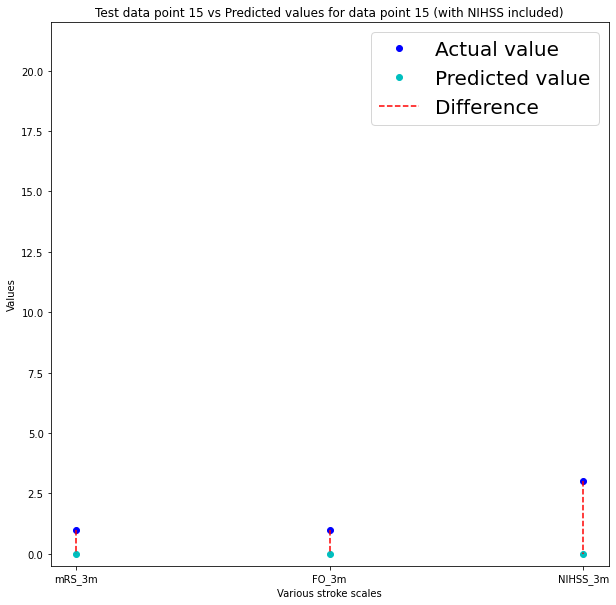

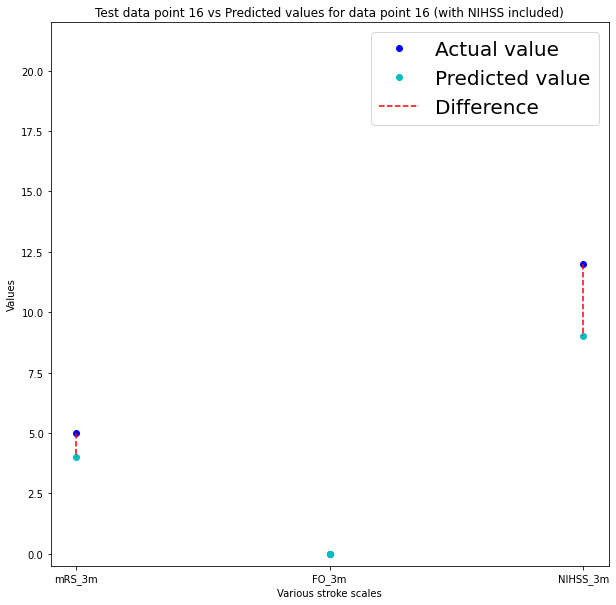

In [143]:
linspace = list(long_term_target_w_NIHSS.columns)

for i in range(0 ,len(test_label)):
    plt.figure(figsize=(10,10))
    plt.ylim(-0.5,22)
    plt.plot(linspace, test_label[i],'bo', linestyle='None')
    plt.plot(linspace, np.round(preds[i]),'co', linestyle='None')
    plt.vlines(linspace, test_label[i], np.round(preds[i]),'r' ,linestyle = '--')
    plt.title(f'Test data point {str(i+1)} vs Predicted values for data point {str(i+1)} (with NIHSS included)')
    plt.xlabel('Various stroke scales')
    plt.ylabel('Values')
    plt.legend(('Actual value', 'Predicted value', 'Difference'), prop={'size':20})
    plt.savefig('./Spanish Data Value vs Predicted value case' + str(i+1) +' (with NIHSS included).jpg')